[I 2025-07-13 17:12:47,285] A new study created in memory with name: no-name-733e4412-fe8b-4368-b28b-ede752965044


加载数据...
训练集大小: (32015, 16), 测试集大小: (10329, 16)
准备特征和目标变量...
添加时间特征...
按时间排序数据...

开始Optuna联合调参...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-13 17:13:50,485] Trial 0 finished with value: 0.8130968725341361 and parameters: {'xgb_max_depth': 3, 'xgb_learning_rate': 0.16146138150230852, 'xgb_subsample': 0.997599401167053, 'xgb_colsample_bytree': 0.9624760485575751, 'xgb_gamma': 0.02803635798321724, 'xgb_reg_alpha': 0.14193492148425535, 'xgb_reg_lambda': 0.9575012936579881, 'lgb_num_leaves': 43, 'lgb_learning_rate': 0.1553601464523848, 'lgb_subsample': 0.9540640618919387, 'lgb_colsample_bytree': 0.9772965146493264, 'lgb_reg_alpha': 0.03868692928847928, 'lgb_reg_lambda': 0.49492466116114964, 'cb_depth': 5, 'cb_learning_rate': 0.01787915703659058, 'cb_l2_leaf_reg': 4.90161268433256, 'cb_random_strength': 1.318190916880664, 'weight_xgb': 0.3549064902464588, 'weight_lgb': 0.5348793813613268, 'weight_cb': 0.8782376515867912}. Best is trial 0 with value: 0.8130968725341361.
[I 2025-07-13 17:14:13,506] Trial 1 finished with value: 0.8032320108219064 and parameters: {'xgb_max_depth': 7, 'xgb_learning_rate': 0.165436448815976

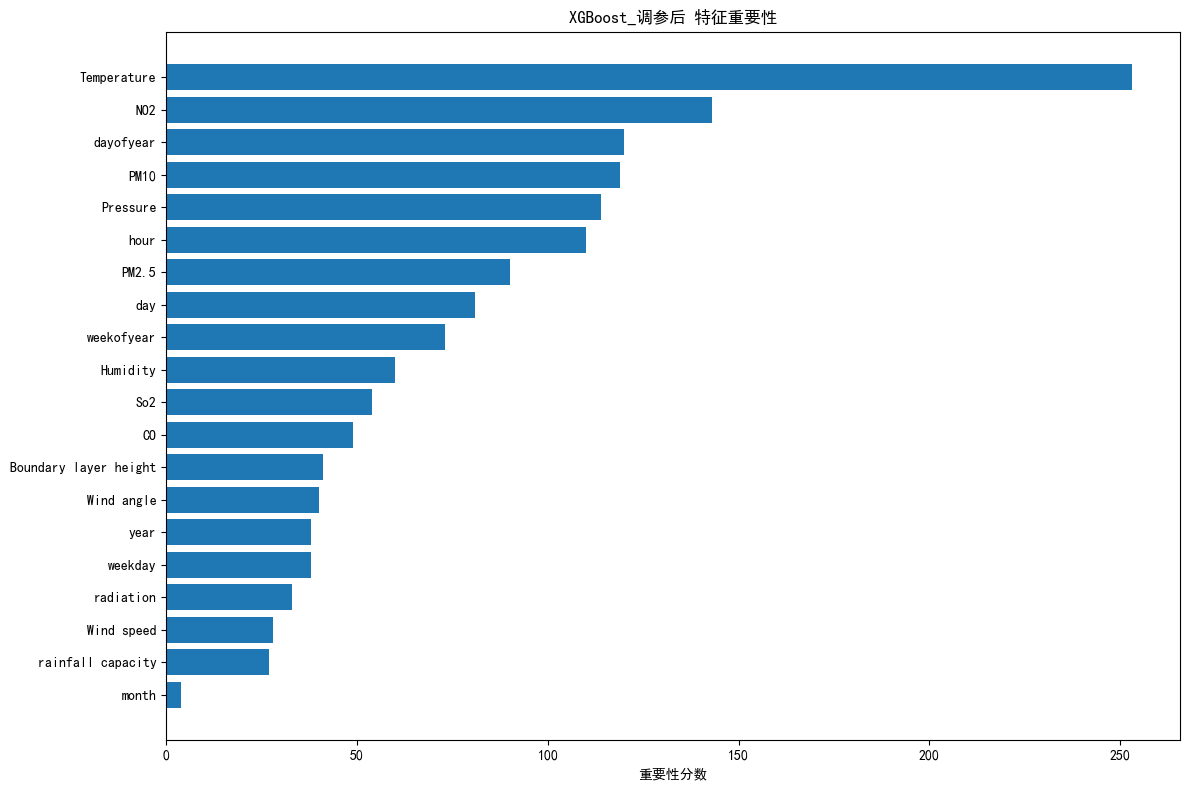

绘制LightGBM特征重要性...


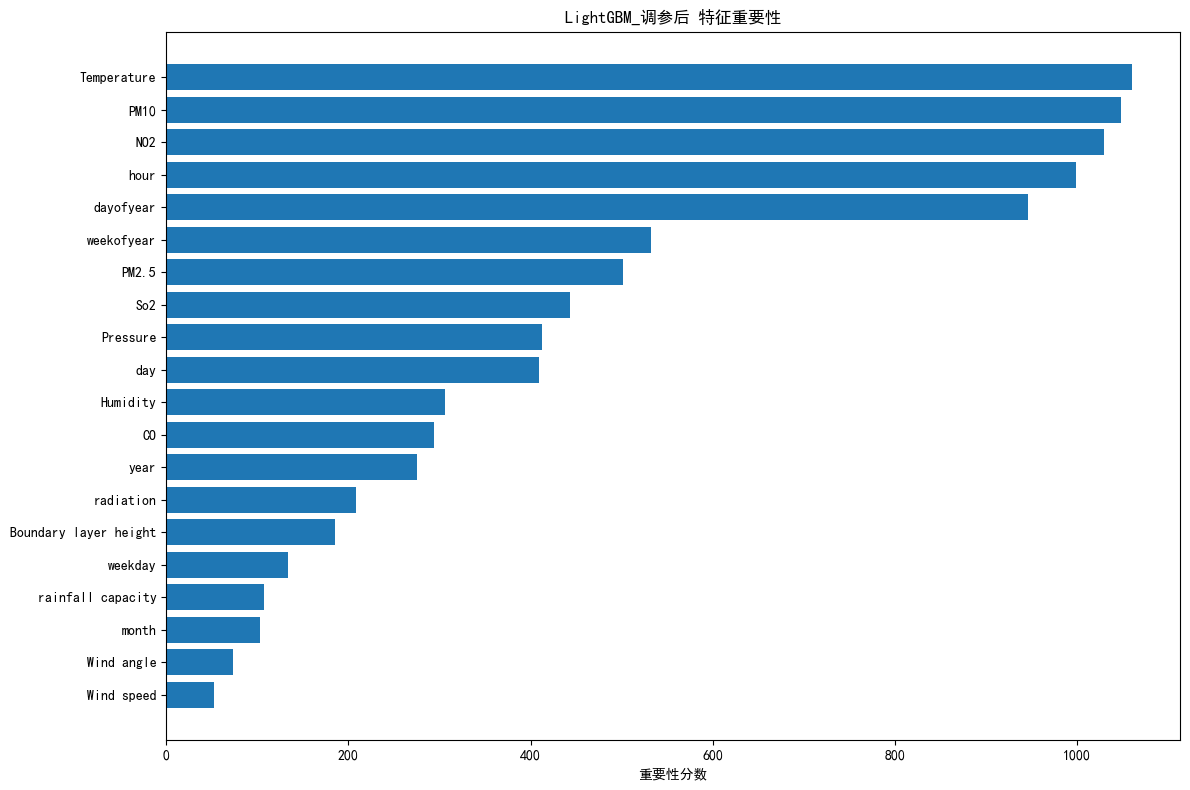

绘制CatBoost特征重要性...


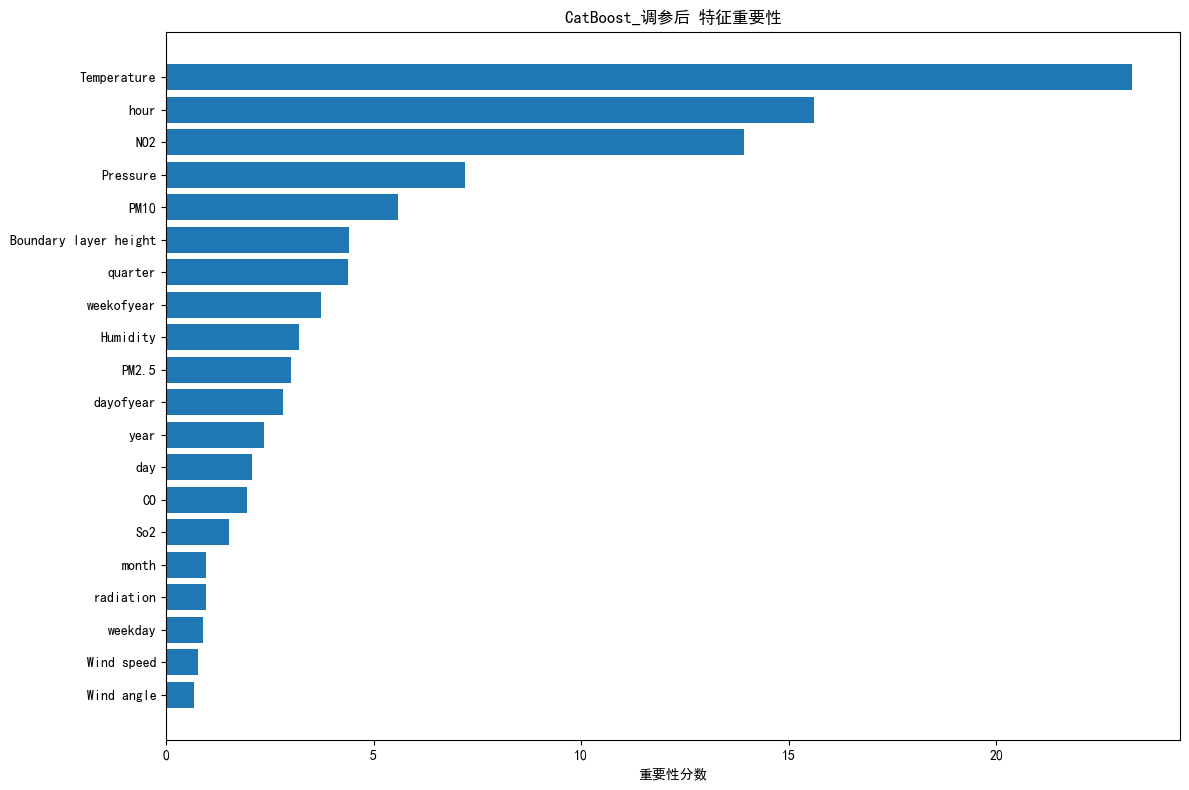

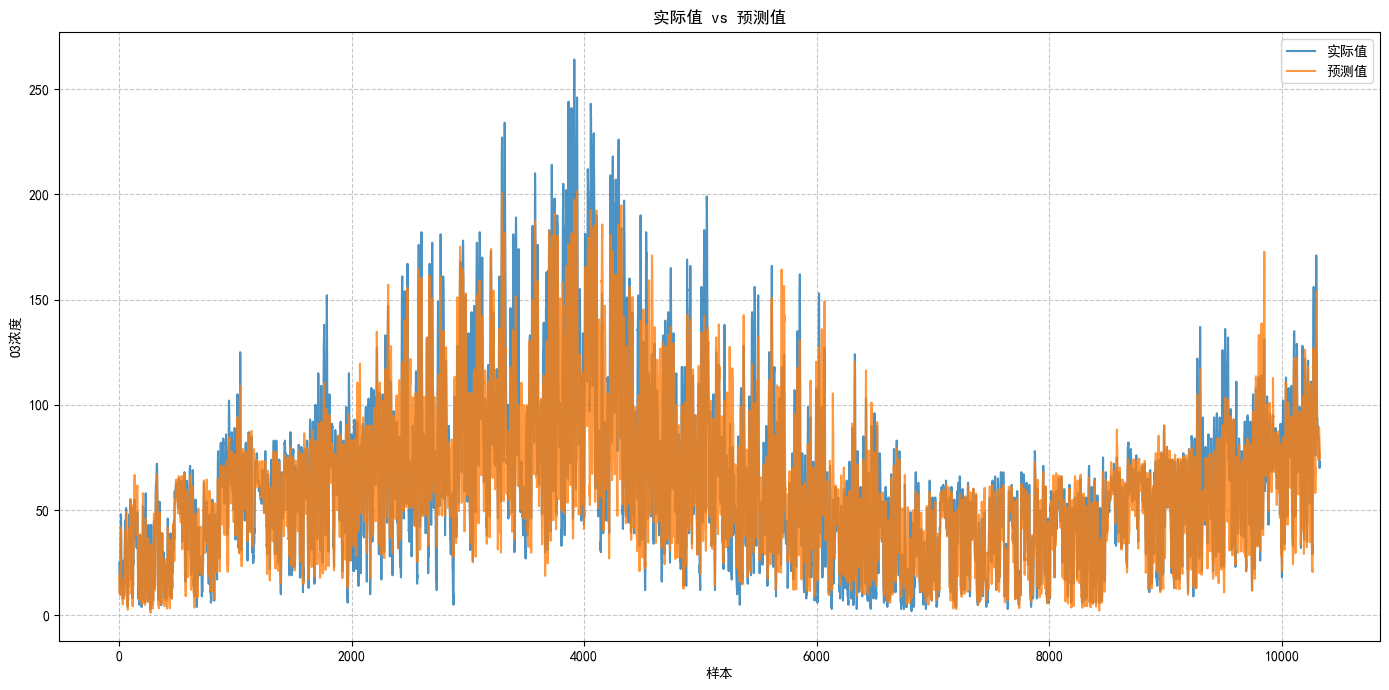

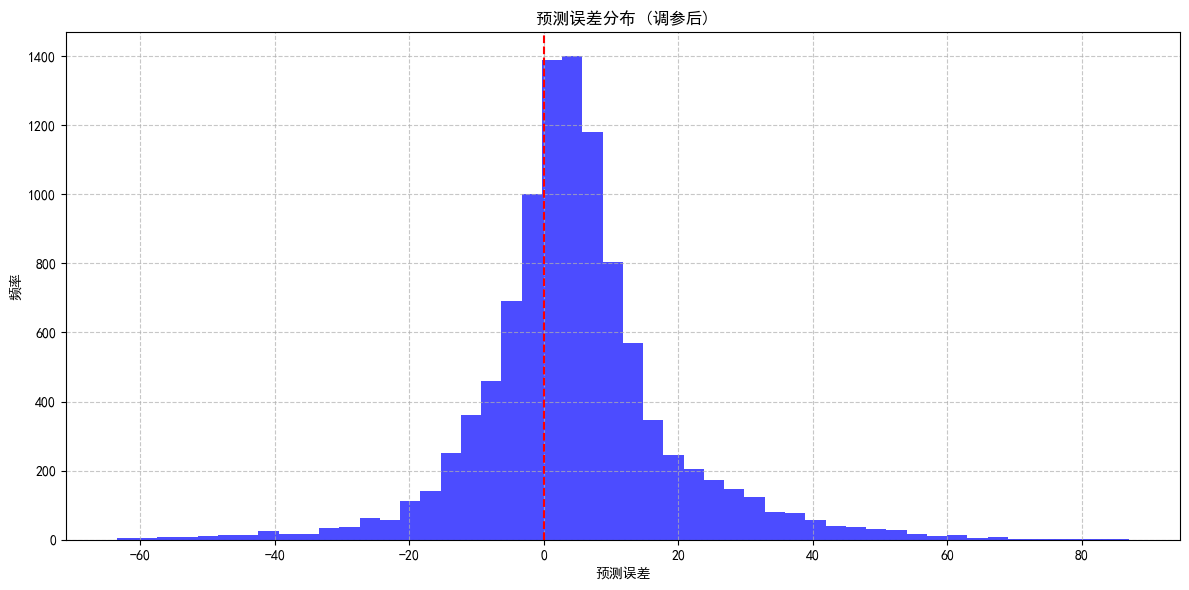

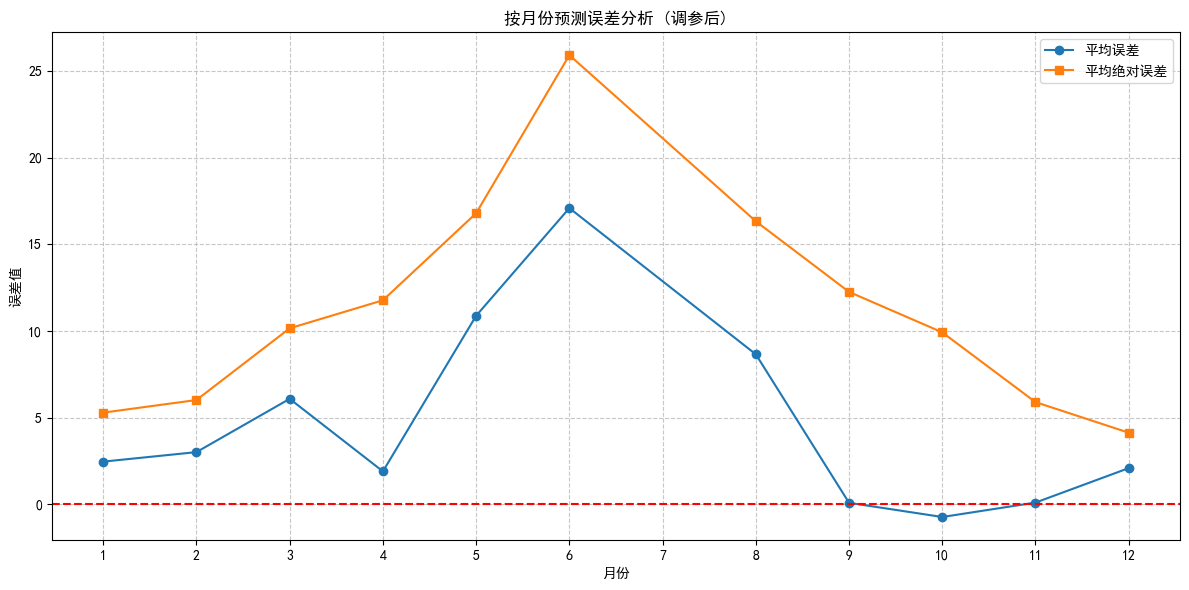


保存模型和调参结果...
集成模型已保存为 'ensemble_model_tuned.pkl'
单个模型已保存
调参结果已保存为 'tuning_results.pkl'

调参结果报告

最优超参数:
{'xgb_max_depth': 4, 'xgb_learning_rate': 0.1807950785624966, 'xgb_subsample': 0.7053759626493663, 'xgb_colsample_bytree': 0.8828131895226968, 'xgb_gamma': 0.35934246373377965, 'xgb_reg_alpha': 0.20319592703130074, 'xgb_reg_lambda': 0.8408069674203774, 'lgb_num_leaves': 20, 'lgb_learning_rate': 0.01470114006375818, 'lgb_subsample': 0.8750938289142933, 'lgb_colsample_bytree': 0.810559470386882, 'lgb_reg_alpha': 0.37829489457428417, 'lgb_reg_lambda': 0.690342235178693, 'cb_depth': 6, 'cb_learning_rate': 0.1748908783612532, 'cb_l2_leaf_reg': 4.4363718307260225, 'cb_random_strength': 7.962250751069595, 'weight_xgb': 0.3741702651704778, 'weight_lgb': 0.7884921181688641, 'weight_cb': 0.9964732787516146}

测试集评估:
R²: 0.8597
MAE: 10.4911

总运行时间: 452.75秒


总运行时间: 452.75秒


In [1]:
##############################
#######ensemble_model#########
##############################
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt
import joblib
import time
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from datetime import datetime
import warnings

# 忽略不必要的警告
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# 记录开始时间
start_time = time.time()

# 设置显示选项
pd.set_option('display.max_columns', None)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 加载数据
print("加载数据...")
train_val_data = pd.read_csv('D:\\2024test.csv')
test_data = pd.read_csv('D:\\2025test.csv')
print(f"训练集大小: {train_val_data.shape}, 测试集大小: {test_data.shape}")

# 添加时间特征（基于yyyymmdd格式的date列）
def add_time_features(df):
    # 确保日期列是整数或字符串类型
    df['date'] = df['date'].astype(str)
    
    # 转换日期格式
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    
    # 提取时间特征
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday  # 周一=0，周日=6
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)  # 确保为整数
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['is_weekend'] = (df['weekday'] >= 5).astype(int)
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    
    # 删除原始date列（保留派生特征）
    df = df.drop(columns=['date'])
    return df

# 准备特征和目标变量
print("准备特征和目标变量...")
X_train_val = train_val_data.drop(columns=['O3'])  # 保留date列
y_train_val = train_val_data['O3']

X_test = test_data.drop(columns=['O3'])  # 保留date列
y_test = test_data['O3']

# 添加时间特征
print("添加时间特征...")
X_train_val = add_time_features(X_train_val)
X_test = add_time_features(X_test)

# 确保数据按时间排序
print("按时间排序数据...")
X_train_val = X_train_val.sort_values(by=['year', 'month', 'day'])
y_train_val = y_train_val.iloc[X_train_val.index]

# 优化数据类型以减少内存使用
def optimize_memory(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == 'int64':
            # 检查数值范围
            c_min = df[col].min()
            c_max = df[col].max()
            if c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype('int32')
            else:
                df[col] = df[col].astype('int64')
        elif col_type == 'float64':
            df[col] = df[col].astype('float32')
    return df

X_train_val = optimize_memory(X_train_val)
X_test = optimize_memory(X_test)

# ======================================
# 联合调参模块（使用原生API解决兼容性问题）
# ======================================
print("\n开始Optuna联合调参...")

# 定义混合模型的目标函数
def objective(trial):
    # XGBoost 参数
    xgb_params = {
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 8),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('xgb_subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_float('xgb_gamma', 0.0, 0.5),
        'reg_alpha': trial.suggest_float('xgb_reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('xgb_reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'tree_method': 'hist',
        'n_jobs': -1
    }
    
    # LightGBM 参数（使用原生API）
    lgb_params = {
        'num_leaves': trial.suggest_int('lgb_num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('lgb_learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('lgb_subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('lgb_colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('lgb_reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('lgb_reg_lambda', 0.0, 1.0),
        'random_state': 42,
        'verbosity': -1  # 不显示警告
    }
    
    # CatBoost 参数
    cb_params = {
        'depth': trial.suggest_int('cb_depth', 3, 8),
        'learning_rate': trial.suggest_float('cb_learning_rate', 0.01, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('cb_l2_leaf_reg', 0.1, 10.0),
        'random_strength': trial.suggest_float('cb_random_strength', 0.1, 10.0),
        'random_state': 42,
        'verbose': False
    }
    
    # 时间序列交叉验证
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    
    for train_idx, val_idx in tscv.split(X_train_val):
        X_train_fold, X_val_fold = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
        
        # 使用原生API训练XGBoost
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
        xgb_model = xgb.train(
            xgb_params,
            dtrain,
            num_boost_round=500,
            evals=[(dval, 'eval')],
            early_stopping_rounds=20,
            verbose_eval=False
        )
        
        # 使用原生API训练LightGBM
        train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
        val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)
        lgb_model = lgb.train(
            lgb_params,
            train_data,
            num_boost_round=500,
            valid_sets=[val_data],
            callbacks=[
                lgb.early_stopping(stopping_rounds=20, verbose=False),
                lgb.log_evaluation(period=0)  # 不显示日志
            ]
        )
        
        # 训练CatBoost
        cb_model = CatBoostRegressor(
            iterations=500,
            **cb_params
        )
        cb_model.fit(
            X_train_fold, y_train_fold,
            eval_set=(X_val_fold, y_val_fold),
            early_stopping_rounds=20,
            verbose=False
        )
        
        # 权重调参
        weights = [
            trial.suggest_float('weight_xgb', 0.1, 1.0),
            trial.suggest_float('weight_lgb', 0.1, 1.0),
            trial.suggest_float('weight_cb', 0.1, 1.0)
        ]
        
        # 验证集预测
        y_pred_xgb = xgb_model.predict(dval)
        y_pred_lgb = lgb_model.predict(X_val_fold)
        y_pred_cb = cb_model.predict(X_val_fold)
        
        # 加权平均预测
        y_pred = (weights[0]*y_pred_xgb + weights[1]*y_pred_lgb + weights[2]*y_pred_cb) / sum(weights)
        score = r2_score(y_val_fold, y_pred)
        scores.append(score)
    
    return np.mean(scores)

# 创建Optuna研究对象
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar=True)

# 输出最优超参数
print("="*50)
print("最优超参数：")
for key, value in study.best_params.items():
    print(f"{key}: {value}")
print("最优R2值（交叉验证）：", study.best_value)

# 使用最优超参数创建最终模型
best_params = study.best_params

# 提取各模型参数
xgb_params = {
    'max_depth': best_params['xgb_max_depth'],
    'learning_rate': best_params['xgb_learning_rate'],
    'subsample': best_params['xgb_subsample'],
    'colsample_bytree': best_params['xgb_colsample_bytree'],
    'gamma': best_params['xgb_gamma'],
    'reg_alpha': best_params['xgb_reg_alpha'],
    'reg_lambda': best_params['xgb_reg_lambda'],
    'random_state': 42,
    'tree_method': 'hist',
    'n_jobs': -1
}

lgb_params = {
    'num_leaves': best_params['lgb_num_leaves'],
    'learning_rate': best_params['lgb_learning_rate'],
    'subsample': best_params['lgb_subsample'],
    'colsample_bytree': best_params['lgb_colsample_bytree'],
    'reg_alpha': best_params['lgb_reg_alpha'],
    'reg_lambda': best_params['lgb_reg_lambda'],
    'random_state': 42,
    'n_jobs': -1
}

cb_params = {
    'depth': best_params['cb_depth'],
    'learning_rate': best_params['cb_learning_rate'],
    'l2_leaf_reg': best_params['cb_l2_leaf_reg'],
    'random_strength': best_params['cb_random_strength'],
    'random_state': 42,
    'verbose': False,
    'thread_count': -1
}

# 创建最终模型实例
# 注意：这里只创建模型对象，不设置迭代次数
xgb_final = XGBRegressor(**xgb_params)
lgb_final = LGBMRegressor(**lgb_params)
cb_final = CatBoostRegressor(**cb_params)

# ======================================
# 训练最终模型（使用原生API解决兼容性问题）
# ======================================
print("\n训练最终混合模型（使用早停机制）...")

# 划分验证集用于早停（时间序列的最后10%）
n_samples = len(X_train_val)
val_size = int(n_samples * 0.1)
X_train_final = X_train_val.iloc[:-val_size]
y_train_final = y_train_val.iloc[:-val_size]
X_val_final = X_train_val.iloc[-val_size:]
y_val_final = y_train_val.iloc[-val_size:]

# 训练XGBoost（使用原生API）
print("训练XGBoost...")
dtrain = xgb.DMatrix(X_train_final, label=y_train_final)
dval = xgb.DMatrix(X_val_final, label=y_val_final)
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=500,
    evals=[(dval, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=False
)

# 训练LightGBM（使用原生API）
print("训练LightGBM...")
train_data = lgb.Dataset(X_train_final, label=y_train_final)
val_data = lgb.Dataset(X_val_final, label=y_val_final, reference=train_data)
lgb_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=500,
    valid_sets=[val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=20, verbose=False),
        lgb.log_evaluation(period=0)  # 不显示日志
    ]
)

# 训练CatBoost（使用scikit-learn接口）
print("训练CatBoost...")
cb_final.fit(
    X_train_final, y_train_final,
    eval_set=(X_val_final, y_val_final),
    early_stopping_rounds=20,
    verbose=False
)

# 创建最终混合模型
final_ensemble = VotingRegressor(
    estimators=[
        ('xgb', XGBRegressor(**xgb_params)),  # 仅用于占位
        ('lgb', LGBMRegressor(**lgb_params)),  # 仅用于占位
        ('cb', cb_final)
    ],
    weights=[
        best_params['weight_xgb'],
        best_params['weight_lgb'],
        best_params['weight_cb']
    ]
)

# 手动设置集成模型中的模型
final_ensemble.estimators_ = [('xgb', xgb_model), ('lgb', lgb_model), ('cb', cb_final)]

# 自定义预测函数
def custom_predict(X):
    # XGBoost预测（需要转换为DMatrix）
    dX = xgb.DMatrix(X)
    y_pred_xgb = xgb_model.predict(dX)
    
    # LightGBM预测
    y_pred_lgb = lgb_model.predict(X)
    
    # CatBoost预测
    y_pred_cb = cb_final.predict(X)
    
    # 加权平均
    weights = [
        best_params['weight_xgb'],
        best_params['weight_lgb'],
        best_params['weight_cb']
    ]
    total_weight = sum(weights)
    
    return (weights[0] * y_pred_xgb + weights[1] * y_pred_lgb + weights[2] * y_pred_cb) / total_weight

# 设置自定义预测函数
final_ensemble.predict = custom_predict

# ======================================
# 在测试集上评估
# ======================================
print("\n在测试集上评估模型...")
y_pred = final_ensemble.predict(X_test)
test_r2 = r2_score(y_test, y_pred)
test_mae = mean_absolute_error(y_test, y_pred)

print("="*50)
print(f"测试集评估结果:")
print(f"R² (决定系数): {test_r2:.4f}")
print(f"MAE (平均绝对误差): {test_mae:.4f}")
print("="*50)

# ======================================
# 特征重要性分析
# ======================================
print("\n特征重要性分析:")
feature_names = X_train_val.columns.tolist()

def plot_feature_importance(importance, names, model_type):
    # 创建DataFrame以便排序
    if isinstance(importance, dict):
        # 处理XGBoost原生API的重要性字典
        feature_importance = pd.DataFrame({
            'feature': list(importance.keys()),
            'importance': list(importance.values())
        })
    else:
        # 处理数组形式的重要性
        feature_importance = pd.DataFrame({
            'feature': names,
            'importance': importance
        })
    
    # 按重要性排序
    feature_importance = feature_importance.sort_values('importance', ascending=True).tail(20)  # 只显示最重要的20个
    
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importance['feature'], feature_importance['importance'])
    plt.title(f'{model_type} 特征重要性')
    plt.xlabel('重要性分数')
    plt.tight_layout()
    plt.savefig(f'{model_type}_feature_importance.png', dpi=300)
    plt.show()

# 绘制特征重要性
print("绘制XGBoost特征重要性...")
xgb_importance = xgb_model.get_score(importance_type='weight')
plot_feature_importance(xgb_importance, feature_names, 'XGBoost_调参后')

print("绘制LightGBM特征重要性...")
lgb_importance = dict(zip(feature_names, lgb_model.feature_importance()))
plot_feature_importance(lgb_importance, feature_names, 'LightGBM_调参后')

print("绘制CatBoost特征重要性...")
plot_feature_importance(cb_final.feature_importances_, feature_names, 'CatBoost_调参后')

# ======================================
# 模型预测可视化
# ======================================
plt.figure(figsize=(14, 7))
plt.plot(y_test.values, label='实际值', alpha=0.8, linewidth=1.5)
plt.plot(y_pred, label='预测值', alpha=0.8, linewidth=1.5)
plt.title('实际值 vs 预测值')
plt.xlabel('样本')
plt.ylabel('O3浓度')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('actual_vs_predicted_tuned.png', dpi=300)
plt.show()

# ======================================
# 误差分布可视化
# ======================================
errors = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50, alpha=0.7, color='blue')
plt.title('预测误差分布 (调参后)')
plt.xlabel('预测误差')
plt.ylabel('频率')
plt.axvline(x=0, color='red', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('error_distribution_tuned.png', dpi=300)
plt.show()

# ======================================
# 按时间分析误差
# ======================================
# 添加日期信息到测试集
test_data_with_date = test_data.copy()
test_data_with_date['date'] = pd.to_datetime(test_data_with_date['date'], format='%Y%m%d')
test_data_with_date['pred'] = y_pred
test_data_with_date['error'] = errors

# 按月聚合误差
monthly_error = test_data_with_date.groupby(test_data_with_date['date'].dt.month)['error'].mean()
monthly_mae = test_data_with_date.groupby(test_data_with_date['date'].dt.month)['error'].apply(lambda x: np.mean(np.abs(x)))

plt.figure(figsize=(12, 6))
plt.plot(monthly_error.index, monthly_error, marker='o', label='平均误差')
plt.plot(monthly_mae.index, monthly_mae, marker='s', label='平均绝对误差')
plt.title('按月份预测误差分析 (调参后)')
plt.xlabel('月份')
plt.ylabel('误差值')
plt.xticks(range(1, 13))
plt.axhline(y=0, color='red', linestyle='--')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('monthly_error_analysis_tuned.png', dpi=300)
plt.show()

# ======================================
# 保存模型和调参结果
# ======================================
print("\n保存模型和调参结果...")

# 保存最终模型
joblib.dump(final_ensemble, 'ensemble_model_tuned.pkl')
print("集成模型已保存为 'ensemble_model_tuned.pkl'")

# 保存单个模型
xgb_model.save_model('xgb_model.json')
lgb_model.save_model('lgb_model.txt')
cb_final.save_model('cb_model.cbm')
print("单个模型已保存")

# 保存调参结果
tuning_results = {
    'params': study.best_params,
    'test_r2': test_r2,
    'test_mae': test_mae
}

joblib.dump(tuning_results, 'tuning_results.pkl')
print("调参结果已保存为 'tuning_results.pkl'")

# 创建调参结果报告（使用UTF-8编码避免字符问题）
report = f"""
{'='*50}
调参结果报告
{'='*50}

最优超参数:
{study.best_params}

测试集评估:
R²: {test_r2:.4f}
MAE: {test_mae:.4f}

总运行时间: {time.time() - start_time:.2f}秒
"""

with open('tuning_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print(report)

# 计算总运行时间
total_time = time.time() - start_time
print(f"\n总运行时间: {total_time:.2f}秒")

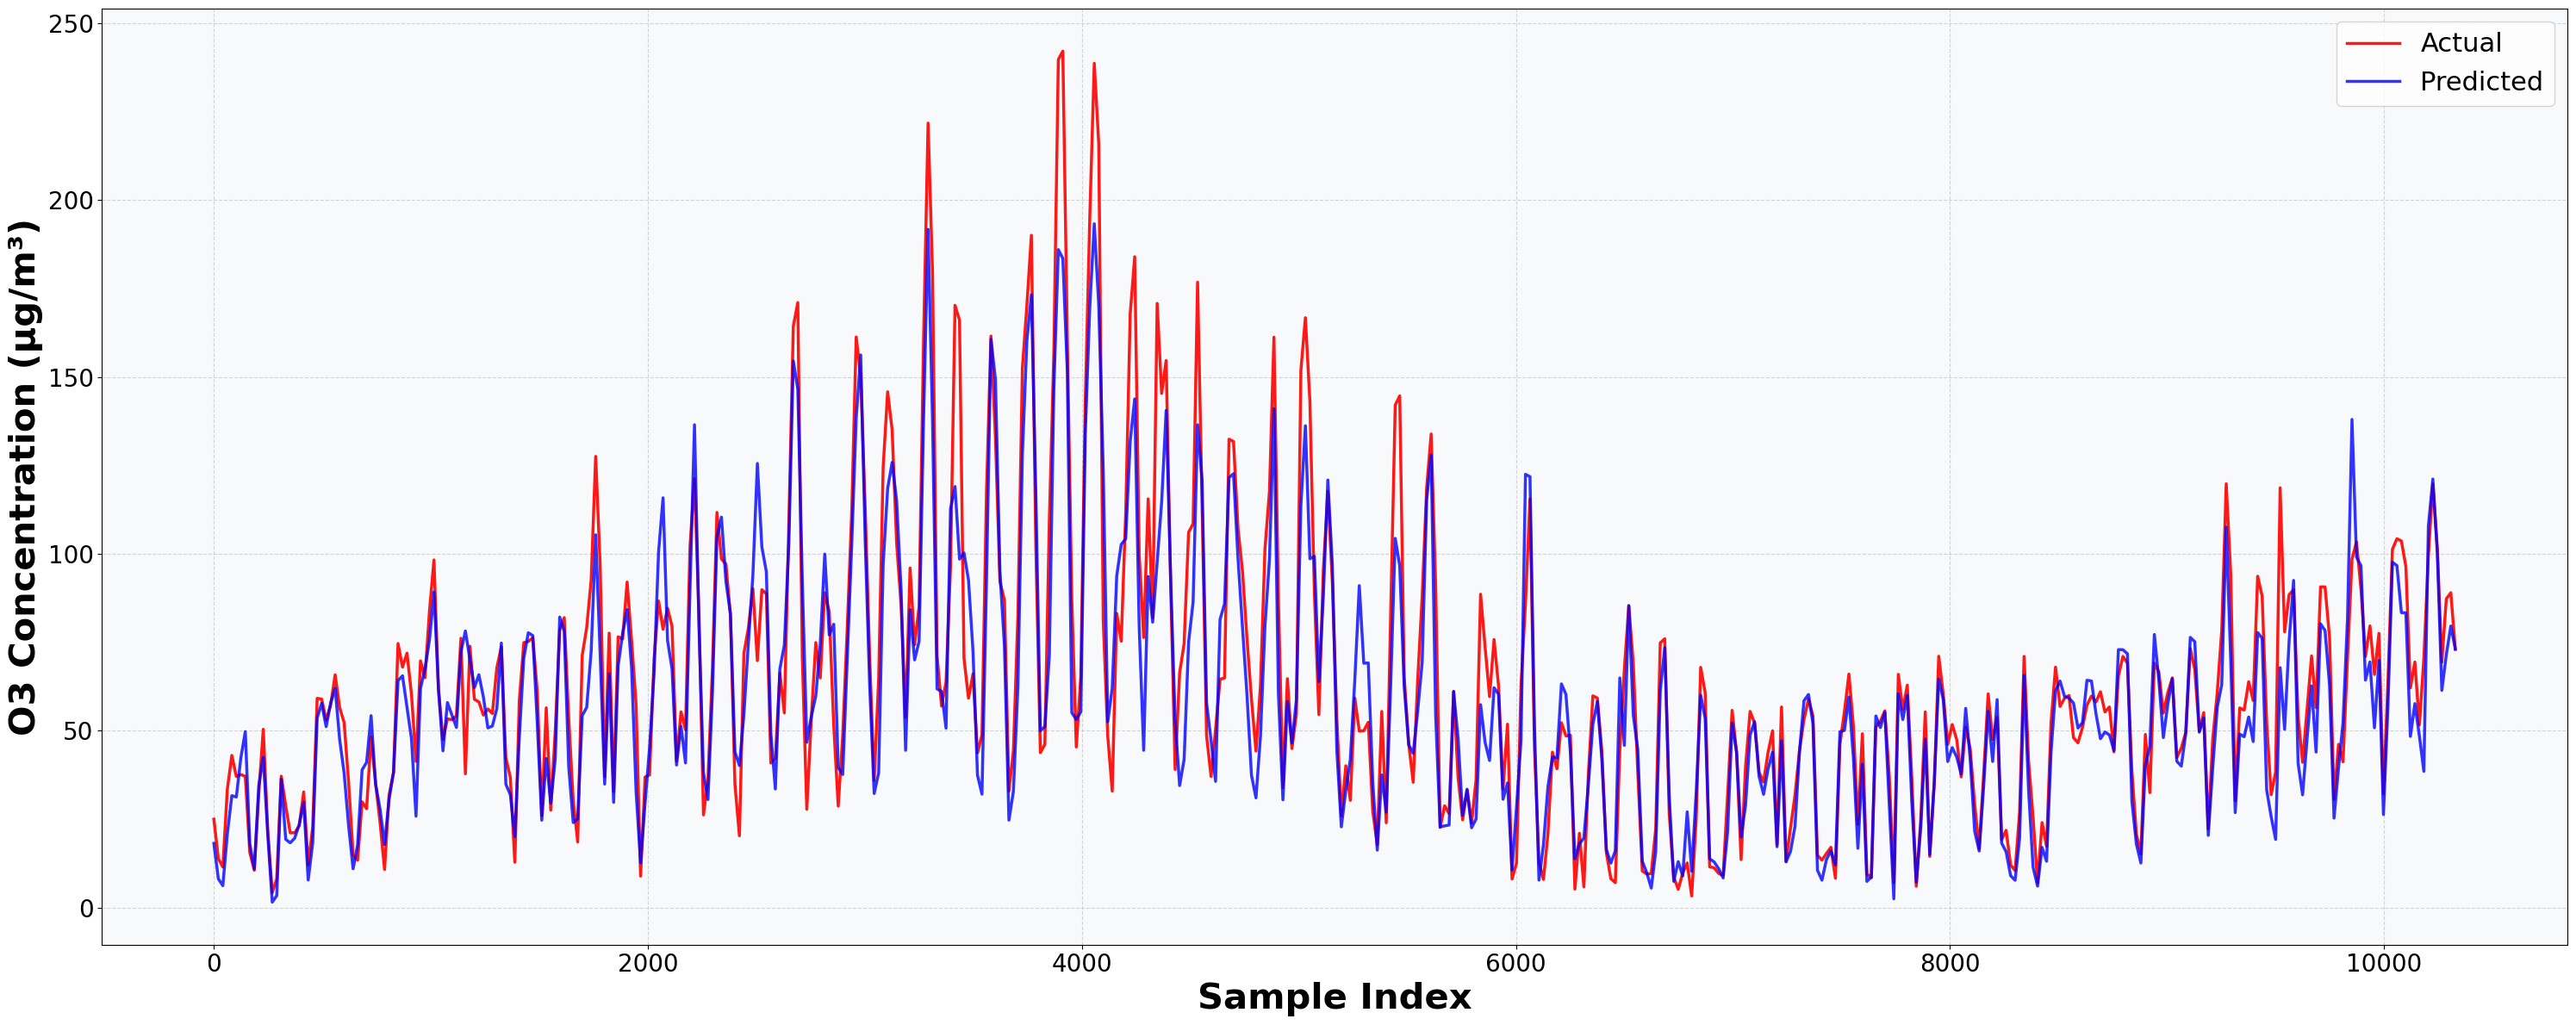

In [39]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

# ======================================
# Model Prediction Visualization (Smoothed Curve Version)
# ======================================

# Enlarge the figure size
plt.figure(figsize=(30, 12))

# Create data points for smoothing
x = np.arange(len(y_test))
x_smooth = np.linspace(x.min(), x.max(), 500)  # Increase interpolation points for smoother curves

# Smooth curve for actual values (red)
if len(y_test) > 3:  # Ensure enough data points for spline interpolation
    spl_actual = make_interp_spline(x, y_test.values, k=3)
    y_actual_smooth = spl_actual(x_smooth)
    plt.plot(x_smooth, y_actual_smooth, 'r-', label='Actual', linewidth=2.5, alpha=0.9)
else:
    plt.plot(y_test.values, 'r-', label='Actual', linewidth=2.5, alpha=0.9)

# Smooth curve for predicted values (blue)
if len(y_pred) > 3:
    spl_pred = make_interp_spline(x, y_pred, k=3)
    y_pred_smooth = spl_pred(x_smooth)
    plt.plot(x_smooth, y_pred_smooth, 'b-', label='Predicted', linewidth=2.5, alpha=0.8)
else:
    plt.plot(y_pred, 'b-', label='Predicted', linewidth=2.5, alpha=0.8)

#plt.title('Actual vs Predicted ', fontsize=30)
plt.xlabel('Sample Index', fontsize=30, fontweight='bold')
plt.ylabel('O3 Concentration (μg/m³)', fontsize=30, fontweight='bold')
plt.legend(fontsize=22)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(fontsize=20)  # 增大横坐标刻度标注字体
plt.yticks(fontsize=20)  # 增大纵坐标刻度标注字体
# Add background color for better readability
plt.gca().set_facecolor('#f8f9fa')

# Adjust layout and save
plt.tight_layout()
plt.savefig('actual_vs_predicted_smooth.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
import shap
import matplotlib.pyplot as plt

# 存储各模型解释器和SHAP值
explainers = {}
shap_values_list = []

# 计算每个基模型的SHAP值
for name, model in final_ensemble.estimators_:
    # 创建对应模型的解释器
    if 'xgb' in name:
        explainer = shap.TreeExplainer(model)
    elif 'lgb' in name:
        explainer = shap.TreeExplainer(model)
    elif 'cb' in name:
        explainer = shap.TreeExplainer(model)
    
    # 计算SHAP值
    shap_values = explainer.shap_values(X_test)
    explainers[name] = explainer
    shap_values_list.append(shap_values)

# 获取权重
weights = final_ensemble.weights

# 计算加权SHAP值
weighted_shap = sum(
    w * val for w, val in zip(weights, shap_values_list)
) / sum(weights)  # 归一化权重

# 计算加权基线值
base_value = sum(
    w * explainers[name].expected_value 
    for w, (name, _) in zip(weights, final_ensemble.estimators_)
) / sum(weights)

# 创建图形并可视化集成模型解释
plt.figure(figsize=(10, 8))  # 设置图形大小
shap.summary_plot(weighted_shap, X_test, plot_type="dot", max_display=12, show=False)

# 自定义图表外观
#plt.title("Feature Importance - Weighted SHAP Values", fontsize=16)
plt.xlabel("SHAP Value (Impact on Prediction)", fontsize=12,fontweight='bold')
plt.ylabel("Features", fontsize=12,fontweight='bold')
plt.xticks(fontsize=10,fontweight='bold')
plt.yticks(fontsize=10,fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.3)

# 保存高质量图片
plt.tight_layout()  # 确保所有元素都能显示
plt.savefig("weighted_shap_summary.png", dpi=300, bbox_inches='tight', facecolor='white')
print("SHAP summary plot saved to: weighted_shap_summary.png")

# 关闭图形以释放内存
plt.close()

TypeError: summary_legacy() got an unexpected keyword argument 'fontweight'

<Figure size 1000x800 with 0 Axes>

In [6]:
print("可用特征列表：", X_test.columns.tolist())

可用特征列表： ['hour', 'So2', 'CO', 'NO2', 'PM2.5', 'PM10', 'Wind speed', 'Wind angle', 'Temperature', 'Humidity', 'Pressure', 'rainfall capacity', 'Boundary layer height', 'radiation', 'year', 'month', 'day', 'weekday', 'weekofyear', 'quarter', 'dayofyear', 'is_weekend', 'is_month_start', 'is_month_end']


In [19]:
import matplotlib.pyplot as plt
import os
import numpy as np
import shap
import pandas as pd

def auto_analyze_shap(shap_values, feature_names, X_test, n_top_features=10, save_dir="shap_plots"):
    """Automatically analyze and visualize top SHAP features and save plots (for academic papers)"""
    # Create output directory
    os.makedirs(save_dir, exist_ok=True)
    
    # Calculate feature importance
    importance = np.abs(shap_values).mean(axis=0)
    top_idx = np.argsort(importance)[-n_top_features:][::-1]
    
    # Generate visualizations
    for i, idx in enumerate(top_idx):
        feat = feature_names[idx]
        rank = i + 1
        print(f"\nAnalyzing feature: {feat} (Importance rank {rank}/{n_top_features})")
        
        # 创建图形并设置白色背景
        plt.figure(figsize=(10, 6), facecolor='white')
        
        # Dependence plot
        shap.dependence_plot(
            idx, shap_values, X_test,
            feature_names=feature_names,
            interaction_index='auto',
            show=False
        )
        
        # 获取当前坐标轴并设置白色背景
        ax = plt.gca()
        ax.set_facecolor('white')
        
        # Customize plot for academic paper
        #plt.title(f"Dependence Plot for '{feat}' (Rank #{rank})", fontsize=14)
        plt.xlabel(f"{feat}", fontsize=12)
        plt.ylabel(f"SHAP Value for {feat}", fontsize=12)
        
        # Improve tick label size
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        
        # Add grid for better readability
        plt.grid(True, linestyle='--', alpha=0.3)
        
        # Save high-quality image with white background
        filename = f"{save_dir}/shap_dependence_{rank:02d}_{feat.replace(' ', '_').replace('/', '_')}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')  # 明确设置白色背景
        print(f"Plot saved to: {filename}")
        plt.close()  # Close figure to free memory
        
        # Output detailed statistics in English
        feature_values = X_test.iloc[:, idx] if isinstance(X_test, pd.DataFrame) else X_test[:, idx]
        shap_values_for_feat = shap_values[:, idx]
        
        print(f"📊 Value range: [{np.min(feature_values):.2f}, {np.max(feature_values):.2f}]")
        print(f"📈 Mean ± SD: {np.mean(feature_values):.2f} ± {np.std(feature_values):.2f}")
        
        corr_coef = np.corrcoef(feature_values, shap_values_for_feat)[0, 1]
        print(f"📐 Correlation with SHAP values: {corr_coef:.2f}")
        
        # Trend analysis in English
        if corr_coef > 0.3:
            print("🔺 Trend: Positive correlation - Higher values increase prediction")
        elif corr_coef < -0.3:
            print("🔻 Trend: Negative correlation - Higher values decrease prediction")
        else:
            print("➖ Trend: Weak correlation - Possible nonlinear relationship")

# Usage example for academic paper
auto_analyze_shap(
    weighted_shap, 
    X_test.columns.values, 
    X_test, 
    n_top_features=10,
    save_dir="shap_analysis_for_paper"
)


Analyzing feature: Temperature (Importance rank 1/10)
Plot saved to: shap_analysis_for_paper/shap_dependence_01_Temperature.png
📊 Value range: [-24.61, 1802.61]
📈 Mean ± SD: 6.29 ± 21.91
📐 Correlation with SHAP values: 0.53
🔺 Trend: Positive correlation - Higher values increase prediction

Analyzing feature: NO2 (Importance rank 2/10)
Plot saved to: shap_analysis_for_paper/shap_dependence_02_NO2.png
📊 Value range: [3.00, 97.00]
📈 Mean ± SD: 31.42 ± 17.04
📐 Correlation with SHAP values: -0.97
🔻 Trend: Negative correlation - Higher values decrease prediction

Analyzing feature: hour (Importance rank 3/10)
Plot saved to: shap_analysis_for_paper/shap_dependence_03_hour.png
📊 Value range: [0.00, 23.00]
📈 Mean ± SD: 11.52 ± 6.93
📐 Correlation with SHAP values: 0.72
🔺 Trend: Positive correlation - Higher values increase prediction

Analyzing feature: PM10 (Importance rank 4/10)
Plot saved to: shap_analysis_for_paper/shap_dependence_04_PM10.png
📊 Value range: [7.00, 955.00]
📈 Mean ± SD: 69.47

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

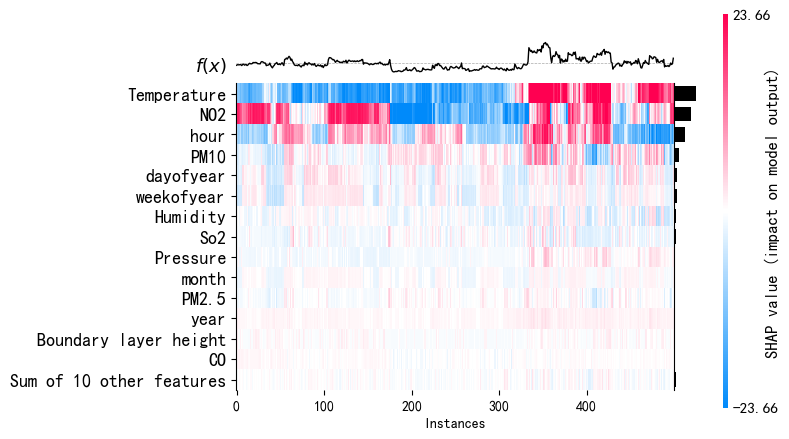

In [4]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 计算每个基模型的SHAP值并加权组合
shap_values_list = []
base_values = []

for name, model in final_ensemble.estimators_:
    # 创建解释器 - 根据模型类型选择最佳方法
    if 'xgb' in name or 'lgb' in name or 'cb' in name:
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.KernelExplainer(model.predict, shap.sample(X_test, 100))
    
    # 计算SHAP值 - 使用小样本加速计算
    sample_data = X_test.sample(min(500, len(X_test)), random_state=42)
    shap_vals = explainer.shap_values(sample_data)
    
    # 存储结果
    shap_values_list.append(shap_vals)
    base_values.append(explainer.expected_value)

# 获取模型权重
weights = final_ensemble.weights
total_weight = sum(weights)

# 计算加权SHAP值
weighted_shap = np.zeros_like(shap_values_list[0])
for i in range(len(shap_values_list)):
    weighted_shap += weights[i] * shap_values_list[i]
weighted_shap /= total_weight

# 计算加权基线值
weighted_base_value = sum(w * b for w, b in zip(weights, base_values)) / total_weight

# 2. 创建Explanation对象（关键步骤）
shap_explanation = shap.Explanation(
    values=weighted_shap,
    base_values=weighted_base_value,
    data=sample_data.values,
    feature_names=X_test.columns.tolist()
)

# 3. 绘制SHAP热力图
plt.figure(figsize=(10, 8))
shap.plots.heatmap(
    shap_explanation,
    max_display=15,  # 显示最重要的15个特征
    show=False  # 避免自动显示，以便自定义
)

# 添加标题和自定义样式
#plt.title("SHAP Values Heatmap for Ensemble Model", fontsize=16, pad=20)
plt.gcf().set_facecolor('white')  # 设置白色背景
plt.tight_layout()
plt.savefig('ensemble_shap_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
print("可用特征列表：", X_test.columns.tolist())

可用特征列表： ['hour', 'So2', 'CO', 'NO2', 'PM2.5', 'PM10', 'Wind speed', 'Wind angle', 'Temperature', 'Humidity', 'Pressure', 'rainfall capacity', 'Boundary layer height', 'radiation', 'year', 'month', 'day', 'weekday', 'weekofyear', 'quarter', 'dayofyear', 'is_weekend', 'is_month_start', 'is_month_end']


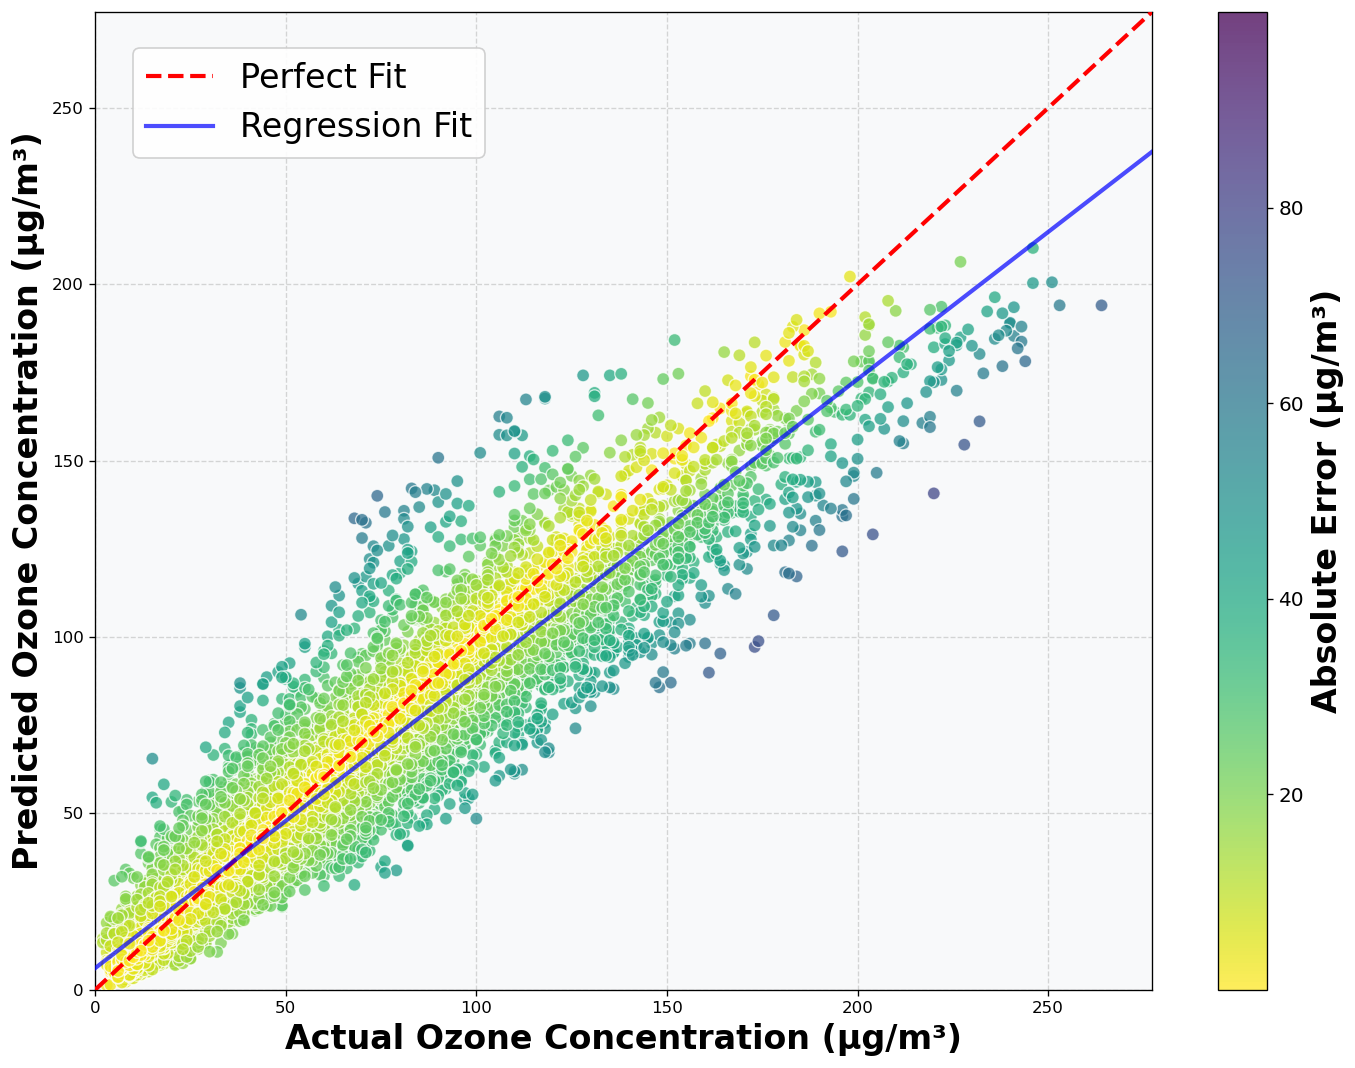

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'  # 使用支持Unicode的字体
plt.figure(figsize=(12, 9), dpi=120)

# 1. 创建散点图 - 移除vmin/vmax设置，使用与代码1相同的参数
scatter = plt.scatter(y_test, y_pred, alpha=0.75,  # 调整为0.75
                     c=np.abs(y_test - y_pred),  # 颜色表示误差大小
                     cmap='viridis_r',  # 反转的颜色映射（与代码1相同）
                     s=60,  # 调整为60
                     edgecolor='w', 
                     linewidth=0.8,  # 调整为0.8
                     zorder=3)  # 添加zorder设置

# 2. 添加完美拟合线（从(0,0)开始）
max_val = max(y_test.max(), y_pred.max()) * 1.05  # 增加5%的边距
perfect_fit, = plt.plot([0, max_val], [0, max_val], 
                      'r--', linewidth=2.5, label='Perfect Fit', zorder=5)  # 调整为2.5，添加zorder

# 3. 添加回归拟合线（从(0,0)开始）
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
x_range = np.linspace(0, max_val, 100)
reg_fit, = plt.plot(x_range, p(x_range), 
                  'b-', linewidth=2.5, alpha=0.7,  # 调整为2.5
                  label='Regression Fit', zorder=5)  # 添加zorder

# 4. 计算两条线之间的夹角
m1 = 1  # 完美拟合线斜率
m2 = z[0]  # 回归线斜率
angle_rad = np.abs(np.arctan((m2 - m1) / (1 + m1 * m2)))
angle_deg = np.degrees(angle_rad)

# 6. 添加颜色条（使用与代码1相同的设置）
cbar = plt.colorbar(scatter)
cbar.set_label('Absolute Error (μg/m³)', fontsize=20, fontweight='bold')  # 添加空格和单位符号
cbar.ax.tick_params(labelsize=12)  # 设置刻度标签大小
# 设置颜色条范围为0-100（可选，因为散点图已经设置了vmin/vmax）
cbar.mappable.set_clim(0, 100)  # 正确的方法是在mappable对象上设置

# 设置自定义刻度：只显示20,40,60,80
cbar.set_ticks([20, 40, 60, 80])
cbar.set_ticklabels(['20', '40', '60', '80'])
# 7. 设置标签和标题
plt.xlabel('Actual Ozone Concentration (μg/m³)', fontsize=20, fontweight='bold')
plt.ylabel('Predicted Ozone Concentration (μg/m³)', fontsize=20, fontweight='bold')
#plt.title('Ensemble Model Optimized Model Performance', fontsize=16, pad=15)  # 修正拼写
plt.legend(fontsize=20, loc='upper left', bbox_to_anchor=(0.02, 0.98), frameon=True, framealpha=0.9)  # 添加框架

# 8. 设置网格和背景
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_facecolor('#f8f9fa')

# 9. 设置坐标轴从(0,0)开始
plt.xlim(0, max_val)
plt.ylim(0, max_val)

plt.tight_layout()
plt.savefig('ozone_prediction_scatter.png', dpi=300, bbox_inches='tight')
plt.show()